In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from unsupervised_random_forest import urf
from sklearn.manifold import MDS

In [2]:
# Change to correct working directory
os.chdir('C:\\Users\\xmste\\OneDrive\\Documents\\Systems Biology\\Year 2\\Scientific Programming\\Project\\SP_squirrels')

# Check working directory
os.getcwd()

'C:\\Users\\xmste\\OneDrive\\Documents\\Systems Biology\\Year 2\\Scientific Programming\\Project\\SP_squirrels'

# Load and explore squirrel dataset
In this section, the squirrel dataset is loaded and various aspects of it are explored.

In [3]:
# Read dataset
squirrels_raw = pd.read_csv('nyc_squirrels.csv')

First, the column containing 'other activities' is explored, to see if there are any particularities to be known about.

In [4]:
# Get other activities that are not NaN
pd.set_option('display.max_rows', None) # display all columns

other_activities_notnan = squirrels_raw["Other Activities"][squirrels_raw["Other Activities"].notnull()]

From the entries in Other Activities, it can be seen that squirrels 144 and 2041 are dead. Thus, these squirrels are removed from the dataset.

In [5]:
# Remove dead squirrels from data
squirrels = squirrels_raw.drop([144, 2041])

# Correct indices, so that the last index is now 3021 and not still 3023
squirrels.reset_index(drop=True, inplace=True)

In [6]:
## Check if removing dead squirrels was succesful

# Check by seeing if dead squirrels still pop up in 'other activities' that are not NaN
other_activities_notnan_live = squirrels["Other Activities"][squirrels["Other Activities"].notnull()]
# print(other_activities_notnan_live)

# Check by printing shapes of original and cleaned data
print(squirrels_raw.shape)
print(squirrels.shape)

(3023, 31)
(3021, 31)


# Preprocessing

For further analysis, we do not want to use all columns in the data; for example, we want to exclude columns that contain comments from the sighters. Then, when the data in these columns contains NaNs, we want to remove these entries.

In [7]:
## Preprocessing

# Select columns to be used for analysis
analysis_columns = ['Hectare', 'Shift', 'Date', 'Age', 'Primary Fur Color', 'Location', 'Running',
                    'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks', 'Quaas', 'Moans',
                    'Tail flags', 'Tail twitches', 'Approaches', 'Indifferent', 'Runs from']

# Remove squirrels that have an NA entry in one of the columns to be used for further analysis
squirrels = squirrels.dropna(subset=analysis_columns)
squirrels.reset_index(drop=True, inplace=True)

# Select subset of data with only columns to be used for further analysis
squirrels_analysis = squirrels[analysis_columns]

# Data visualization
In this section, the data is visualized to get an idea of the information in the dataset.

## Pie charts
To visualize the distribution of squirrels over all variables, pie charts are created for the different variables. The variable Hectare is excluded here, as this contains too many values to visualize in a pie chart.

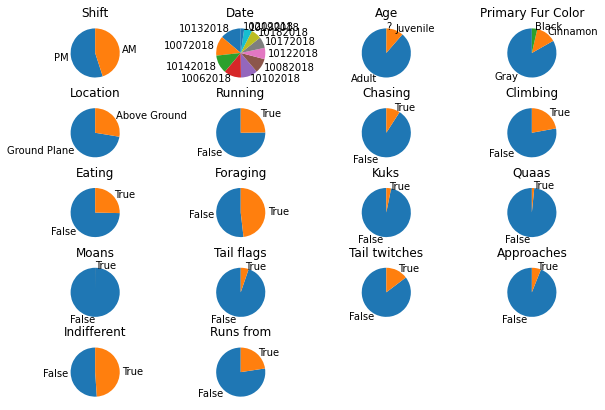

In [8]:
# All variables that are later used in the model, excluding hectare
all_vars = ['Shift', 'Date', 'Age', 'Primary Fur Color', 'Location', 'Running',
            'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks', 'Quaas', 'Moans',
            'Tail flags', 'Tail twitches', 'Approaches', 'Indifferent', 'Runs from']


# Create plot
plt.figure(figsize=(10,7))
plt.subplots_adjust(hspace=0.3)

# Loop over the variables
for n, var in enumerate(all_vars):
    
    # Create new subplot iteratively
    ax = plt.subplot(5, 4, n + 1)

    # Get labels for this variable
    labels = squirrels[var].value_counts().index.tolist()
    
    # Get number of squirrels per label
    values = squirrels[var].value_counts().tolist()
    
    # Create pie chart
    ax.pie(values, labels=labels, startangle = 90)
    ax.set_title(var)
    
# plt.savefig('pie_charts.png')

([<matplotlib.patches.Wedge at 0x1e1629b4d90>,
 [Text(-0.46160973258800597, 0.9984570370226402, '10132018'),
  Text(-1.0517640267584003, 0.32216832869938516, '10072018'),
  Text(-0.9706540367447835, -0.5175236622136778, '10142018'),
  Text(-0.37327988459735395, -1.0347280453119005, '10062018'),
  Text(0.385922622887342, -1.030079477100556, '10102018'),
  Text(0.9326509650083908, -0.5832342389374251, '10082018'),
  Text(1.0997539414177413, -0.02326517432006922, '10122018'),
  Text(0.9943063818439867, 0.47048360122784344, '10172018'),
  Text(0.6965894048192985, 0.8513302538342542, '10182018'),
  Text(0.33268983902168636, 1.0484834147528155, '10192018'),
  Text(0.0783064989725499, 1.0972092290072402, '10202018')])

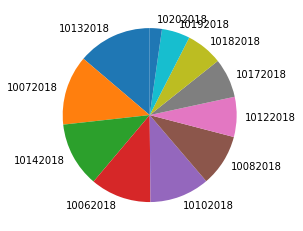

In [9]:
# Plot only pie chart for variable Date to make this more clear

label_test = squirrels['Date'].value_counts().index.tolist()
value_test = squirrels['Date'].value_counts().tolist()
plt.pie(value_test, labels = label_test, startangle = 90)
# plt.savefig('pie_date.png')

## Map squirrel locations
To get an idea of the distribution of squirrels over the park, this section provides code for visualizing the locations of squirrels. This can be done for all squirrels or for various subsets of squirrels (e.g. only squirrels that are black, foraging, or something else). The maps are based on the hectares into which the park has been divided.

In [10]:
## Function for plotting number of squirrels per hectare in the park given a certain subset of squirrels

def plot_positions(squirrel_data):
    
    # Get number of squirrels per hectare
    squirrels_per_hectare = squirrel_data['Hectare'].value_counts()
    
    # Create figure
    plt.figure(figsize=(5,8))

    # Loop through hectares and plot dot relative to number of squirrels in that hectare
    # x-positions are saved by their ASCII value

    for hectare, n_squirrels in squirrels_per_hectare.items():
        y_coord = int(hectare[:2])
        x_coord = ord(hectare[2:])
        plt.scatter(x_coord, y_coord, color='blue', s=n_squirrels)
        
    plt.xticks([65, 66, 67, 68, 69, 70, 71, 72, 73], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])
    plt.show()

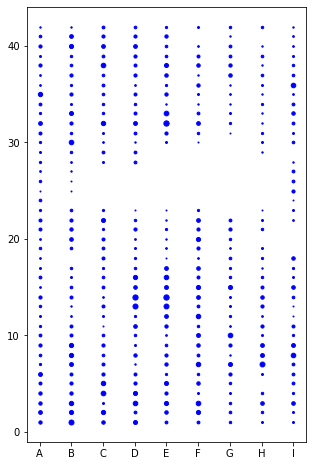

In [11]:
# Plot positions of all squirrels
squirrel_plot = plot_positions(squirrels)

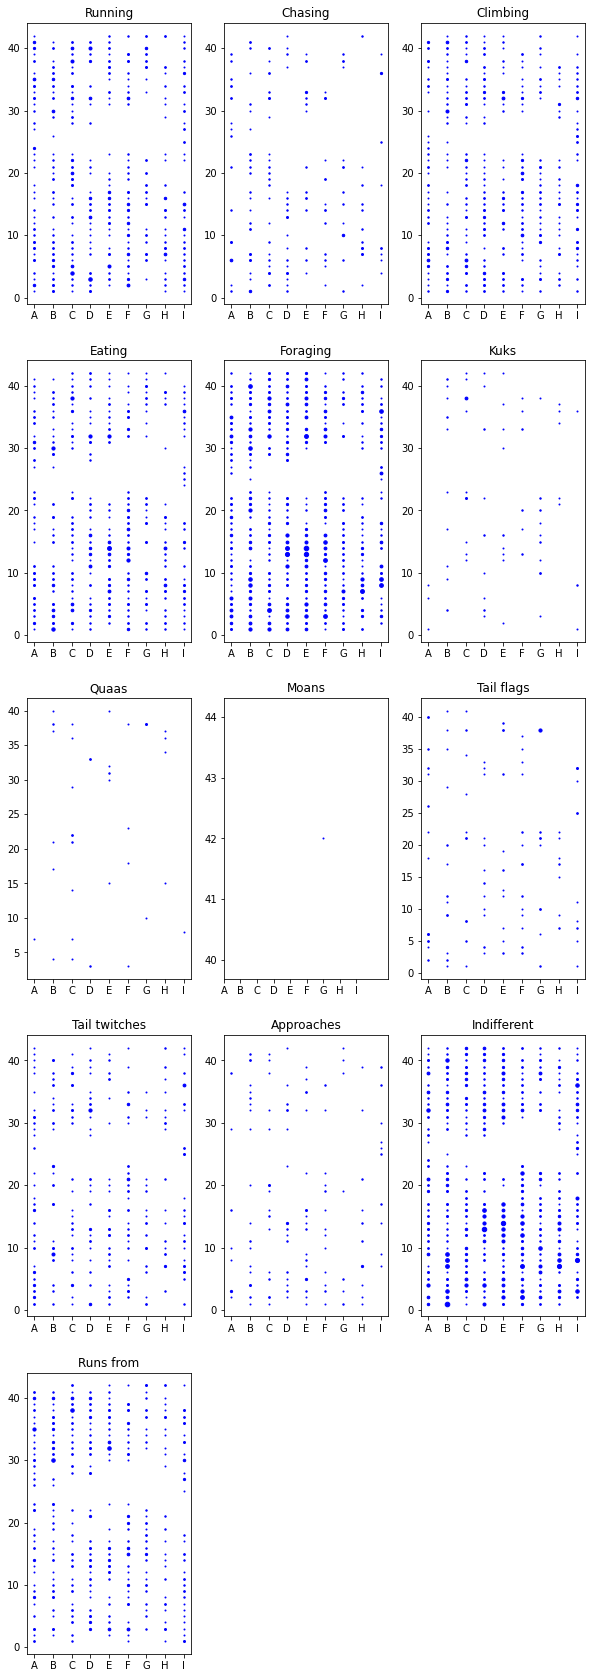

In [12]:
# Create plots of numbers of squirrels per hectare for all boolean variables

bool_vars = ['Running','Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks', 'Quaas', 'Moans', 'Tail flags', 
             'Tail twitches', 'Approaches', 'Indifferent', 'Runs from']

plt.figure(figsize=(10, 30))

# Loop over behaviors (boolean variables)
for n, var in enumerate(bool_vars):
    
    # add a new subplot iteratively
    ax = plt.subplot(5, 3, n + 1)
    
    # Get subset of data for all squirrels showing a certain behavior
    data = squirrels.loc[squirrels[var] == True]
    
    squirrels_per_hectare = data['Hectare'].value_counts()
    for hectare, n_squirrels in squirrels_per_hectare.items():
        y_coord = int(hectare[:2])
        x_coord = ord(hectare[2:])
        ax.scatter(x_coord, y_coord, color='blue', s=n_squirrels)
        
    ax.set_xticks([65, 66, 67, 68, 69, 70, 71, 72, 73], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])
    ax.set_title(var)

In [21]:
## Examples to make plots of non-boolean variables

## Plot positions of all approaching gray squirrels
# squirrels_gray = squirrels.loc[squirrels['Primary Fur Color'] == 'Gray']
# plot_positions(squirrels_gray.loc[squirrels_gray['Approaches'] == True])

## Plot positions per fur color
# plot_positions(squirrels.loc[squirrels['Primary Fur Color'] == 'Gray'])
# plot_positions(squirrels.loc[squirrels['Primary Fur Color'] == 'Black'])
# plot_positions(squirrels.loc[squirrels['Primary Fur Color'] == 'Cinnamon'])

## Plot positions per shift
# plot_positions(squirrels.loc[squirrels['Shift'] == 'AM'])
# plot_positions(squirrels.loc[squirrels['Shift'] == 'PM'])

## Plot positions per location
# plot_positions(squirrels.loc[squirrels['Location'] == 'Ground Plane'])
# plot_positions(squirrels.loc[squirrels['Location'] == 'Above Ground'])

## Plot positions per Age
# plot_positions(squirrels.loc[squirrels['Age'] == 'Adult'])
# plot_positions(squirrels.loc[squirrels['Age'] == 'Juvenile'])

# Data analysis
In this section, various methods are used to further analyze the squirrel data. The goal is to find out whether there are certain subgroups of squirrels.

## Isolation forest

In this section, isolation forest is used on a subset of the variables to get the anomaly score per sample.
The data will be label encoded. Isolation forest will be applied to this encoded data. The anomaly scores will be calculated as averages over 5 different runs of isolation forest.

In [14]:
# Label encode the data
le = LabelEncoder()
squirrels_encoded = squirrels_analysis.apply(lambda col: le.fit_transform(col))    

# Create isolation forest with 1000 trees and fit squirrel data over 5 runs
score_list = []

for i in range(5):
    rng = np.random.RandomState(42)
    clf = IsolationForest(n_estimators=1000, max_samples='auto', random_state=rng, contamination=0.1)

    clf.fit(squirrels_encoded)

    # Calculate anomaly scores from IF
    scores = clf.decision_function(squirrels_encoded)
    original_scores = [-1*s + 0.5 for s in scores]
    score_list.append(np.array(original_scores))
    
# Get average original paper score of 5 runs
original_paper_score = np.mean(score_list, axis = 0)

# Plot distribution of anomaly scores
# plt.bar(x = np.asarray(range(0, len(scores))), height = original_paper_score)

D:\programs\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
D:\programs\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
D:\programs\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
D:\programs\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
D:\programs\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


## Unsupervised random forest and Multidimensional Scaling

In this section, Unsupervised Random Forest (URF) is used on the label encoded data that was also used in Isolation Forest, to get a distance matrix for the samples. On this distance matrix, Multidimensional Scaling (MDS) will be performed to reduce dimensionality and visualize the samples. 

The code for performing Unsupervised Random Forest was taken from https://github.com/ireis/unsupervised-random-forest.

In [15]:
# Function to calculate mean distance matrix over 5 runs of URF
def urf_5(data, n_estimators):
    dist_list = []
    
    for i in range(5):
        
        # Create URF model
        urf_model = urf(n_trees=n_estimators, max_depth=3)
        
        # Get distance matrix from URF and save to list
        distance_mat = urf_model.get_distance(data.to_numpy())
        dist_list.append(distance_mat)
        
    # Calculate average distance matrix over the 5 runs
    dist_mat_mean = np.mean(dist_list, axis = 0)
    
    return dist_mat_mean

In [16]:
# Get distance matrix averaged over 5 runs
squirrels_mean_dist_mat = urf_5(squirrels_encoded, n_estimators=1000)

# Calculate PCo scores from distance matrix
embedding = MDS(n_components=2, dissimilarity='precomputed')
PC_scores_MDS = embedding.fit_transform(squirrels_mean_dist_mat)

PC_scores_MDS = pd.DataFrame(PC_scores_MDS)
# plt.scatter(PC_scores_MDS[0], PC_scores_MDS[1])

The calculated principal coordinates can be plotted against each other. This plot can then be colored with the anomaly scores calculated with Isolation Forest, to see were anomalies in the data are.

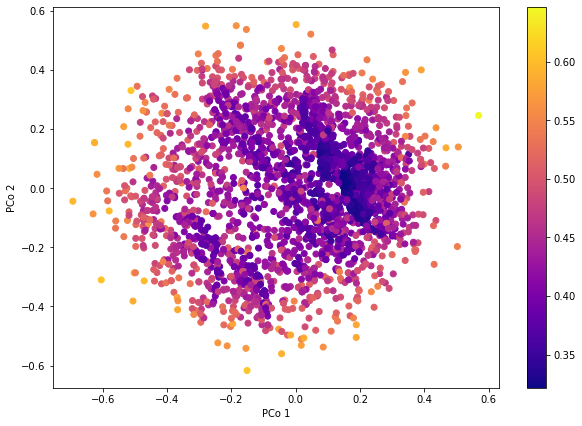

In [17]:
# Color PCoA plots by anomaly score from IF
f, ax = plt.subplots(figsize=(10, 7))
points = ax.scatter(PC_scores_MDS[0], PC_scores_MDS[1], c=list(original_paper_score), cmap='plasma')
ax.set_xlabel('PCo 1')
ax.set_ylabel('PCo 2')
f.colorbar(points)

# plt.savefig('IF_anomaly_final.png')

Next, the plot of the principal coordinates can be colored by different variables in the data.

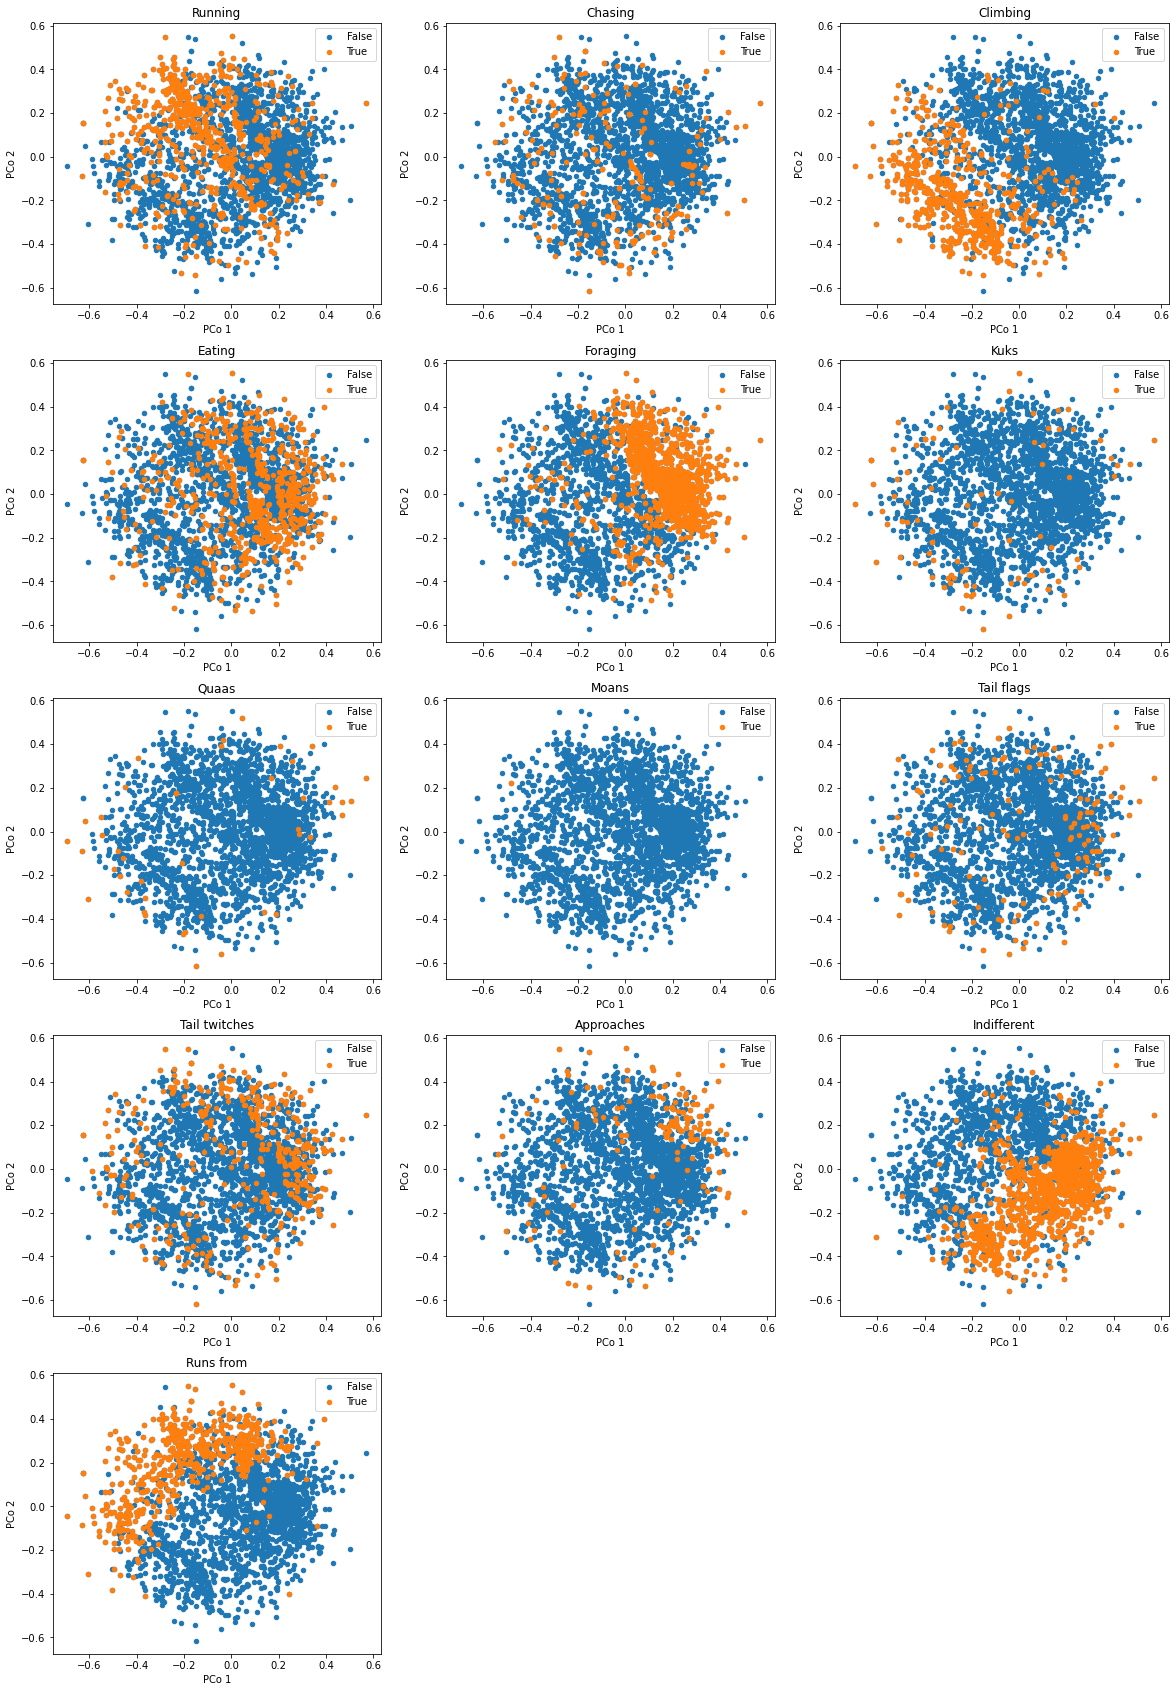

In [18]:
# Color PCo plot by boolean variables

bool_vars = ['Running','Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks', 'Quaas', 'Moans', 'Tail flags', 
             'Tail twitches', 'Approaches', 'Indifferent', 'Runs from']

# Create figure
plt.figure(figsize=(20, 30))

# Make subplots in loop
for n, var in enumerate(bool_vars):
    
    # add a new subplot iteratively
    ax = plt.subplot(5, 3, n + 1)
    
    # Get list of squirrels for which variable is True
    true_ind = squirrels.index[squirrels[var] == True]

    # First plot all squirrels in blue, then color squirrels with True values in orange
    b1 = ax.scatter(PC_scores_MDS[0], PC_scores_MDS[1], c='tab:blue', s=20,label="False")
    b1 = ax.scatter(PC_scores_MDS.iloc[true_ind,0],PC_scores_MDS.iloc[true_ind,1], c='tab:orange',s=20,label="True")

    # Chart formatting
    ax.set_title(var)
    plt.legend(loc="upper right")
    ax.set_xlabel('PCo 1')
    ax.set_ylabel('PCo 2')
    
plt.savefig('PCo_bool_final_ob.png')

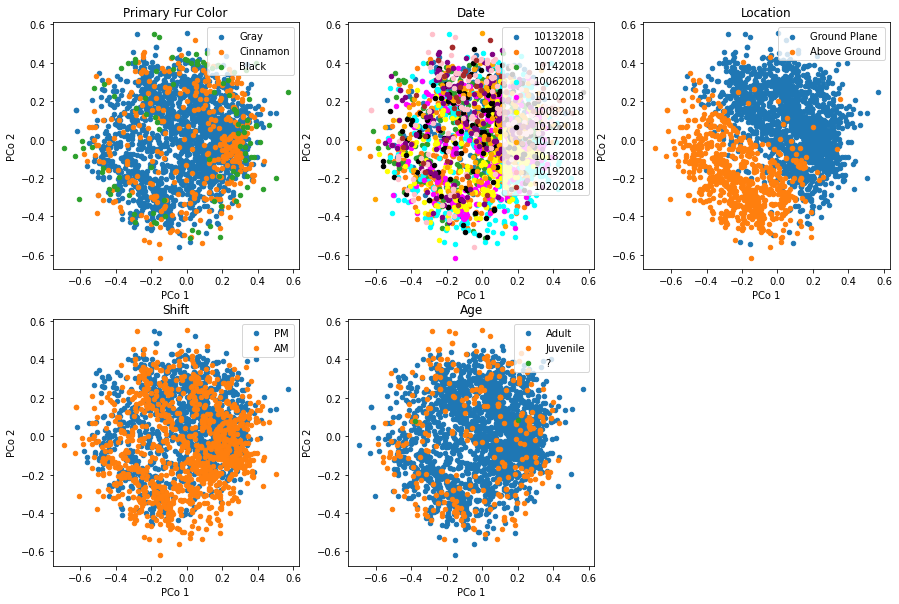

In [19]:
# Color PCo plots for non-boolean variables

plot_colors = ['tab:blue', 'tab:orange', 'tab:green', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'pink', 'brown']
nonbool_vars = ['Primary Fur Color', 'Date', 'Location', 'Shift', 'Age']

# Create figure
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.2)

# Loop over non-boolean variables
for n, nonbool_var in enumerate(nonbool_vars):
    cats = squirrels[nonbool_var].value_counts()
    
    # Loop over values per variable
    for (item, n_squirrels), plot_col in zip(cats.items(), plot_colors):
        
        # add a new subplot iteratively
        ax = plt.subplot(2, 3, n + 1)

        # Get indices for squirrels of current value and plot these samples
        col_ind = squirrels.index[squirrels[nonbool_var] == item]
        ax.scatter(PC_scores_MDS.iloc[col_ind, 0], PC_scores_MDS.iloc[col_ind, 1], c=plot_col, s=20,label=item)

        # chart formatting
        ax.set_title(nonbool_var)
        plt.legend(loc="upper right")
        ax.set_xlabel('PCo 1')
        ax.set_ylabel('PCo 2')
        
plt.savefig('PCo_nonbool_final_nodate_ob_date.png')

## Try URF and MDS with transposed matrix
As a last analysis, URF and MDS will be applied a transposed version of the dataset. Thus, the variables will now be treated as samples. This is to get an idea whether there are variables in the data that cluster together.

0     Text(0.659627652951296, 0.1891211017659263, 'H...
1     Text(0.017437241469402828, 0.2632067785109062,...
2     Text(0.6108697299653094, 0.09532894358302427, ...
3     Text(0.4379303505089697, 0.21449832867389268, ...
4     Text(0.527444324020988, 0.2616136586732012, 'P...
5     Text(0.23750502692772793, 0.22402137204764316,...
6     Text(-0.12411082884761415, -0.1772724659713756...
7     Text(-0.29323595380390627, -0.1213803639943224...
8     Text(-0.18437362637824325, -0.2438876281260780...
9     Text(-0.19575424822538398, 0.06348261021449984...
10    Text(0.0647951203377343, 0.11521987740881393, ...
11    Text(-0.2749225680437165, -0.15678861470051414...
12    Text(-0.28639926989087267, -0.1415883790965769...
13    Text(-0.28225933719395335, -0.1414085837416614...
14    Text(-0.2876396585079202, -0.11028148498717678...
15    Text(-0.23621424263057517, -0.0782491517593645...
16    Text(-0.2698141522486781, -0.146751227183965, ...
17    Text(0.16092581029434308, -0.1279640275368

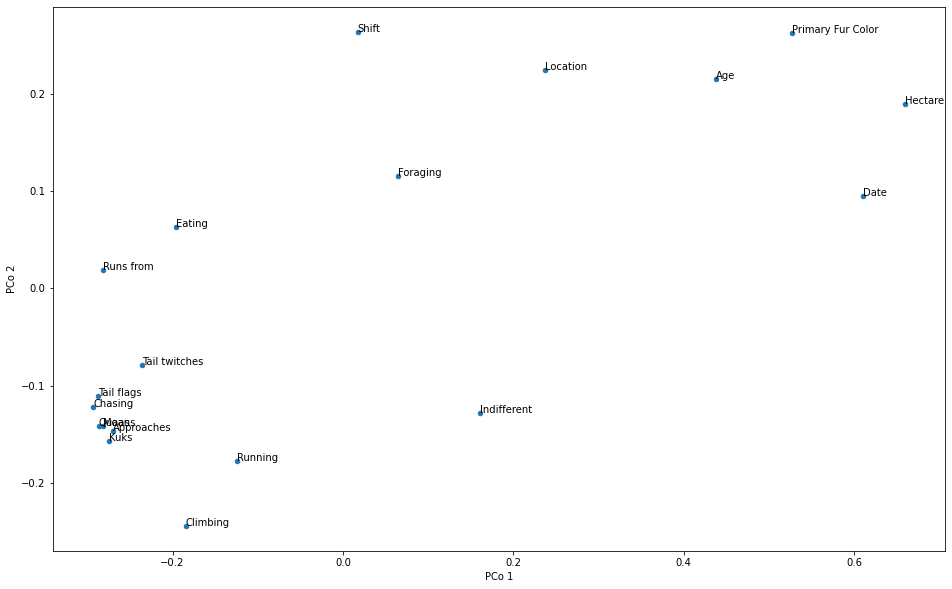

In [20]:
# Get mean distance matrix
dist_mat_mean = urf_5(squirrels_encoded.transpose(), n_estimators=500)

# Calculate PC scores from distance matrix 
embedding_T = MDS(n_components=2, dissimilarity='precomputed')
PC_scores_MDS_T = embedding_T.fit_transform(dist_mat_mean)

# Calculate PcO scores
PC_scores_MDS_T = pd.DataFrame(PC_scores_MDS_T)

# Rename columns
PC_scores_MDS_T = PC_scores_MDS_T.rename(columns={0: 'PCo 1', 1: 'PCo 2'})

# Add variable column
PC_scores_MDS_T['Variable'] = analysis_columns

# Plot PcO scores
ax = PC_scores_MDS_T.plot(x='PCo 1',y='PCo 2',kind='scatter', figsize=(16,10))

# Add variable names to plot
PC_scores_MDS_T[['PCo 1','PCo 2','Variable']].apply(lambda x: ax.text(*x),axis=1)

# plt.savefig('PCo_transposed.png')